# CSE252D: Homework 3
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Sun, Jun 6, at 11:59pm.

## Q1: UNet for Image Segmentation

1. **Check the codes in `Segmentation`.** In this homework, we will provide the dataset loader, the evaluation code, the basic UNet structure and some useful functions. You will be asked to try different variations of network structure and decide the best training strategies to obtain good results. Like in previous homeworks, you are welcome to cite any open source codes that help you improve performance. The provided codes include:
    1. `test.py`: The file for evaluation. 
    2. `dataLoader.py`: The file to load the data for training and testing.  
    3. `model.py`: The file for models. The residual block (`ResBlock`) and the code to load pretrained weights of `resnet18  loadPretrainedWeight`) are given. The basic encoder and decoder are also given as a reference. 
    4. `colormap.mat`: The color map used to visualize segmentation results. 
    5. `utils.py`: The file for two useful functions. The `computeAccuracy` function computes the unnormalized confusion matrix of each batch of labels. The `save\_label` function turns the label into an image using the given color map and saves the image at the assigned location. Also see `test.py` for how these two functions are being used. 
    6. `train.py`: An empty file where you will implement your training script. 

2. **Implement the network structures.**  You are required to implement 2 versions of UNet structure since the basic structure has already been given. In all three versions,  the `resnet18` structure before average pooling and fully connected layer will be used as the building block for encoder. You are strongly recommended to use weights pretrained on ImageNet, which may have a major impact on the performance. 
    1. `Basic UNet`: The code is given as a reference. Please see `encoder` and `decoder` class in `model.py`. The `encoder` comes from `resnet18` and the decoder consists of transpose convolutional layers and bilinear interpolation layers so that the final output will be of the same size as the image. Skip links are added to help the network recover more details. Please do not change the encoder. However, you are free to change the decoder, while ensuring that the structure of your decoder across three versions of the networks are similar so that you can make a fair comparison of their performances. 
    2. `UNet with dilation`: We modify the encoder to a dilated `resnet18` as described in Section 2 of [1] (You are not required to consider degridding in Section 4 of [1] ). We set the stride of the last 4 residual blocks to be 1 so that the highest level feature maps will be $4\times 4$ times larger. To increase the receptive field, we set the dilation of residual blocks that are fourth and third from the end to be 2, while the dilation of the residual blocks that are first and second from the end are set to 4.  The decoder should be modified accordingly. Implement your new encoder and decoder under class `encoderDilation` and `decoderDilation`. Ensure that for images of arbitrary shapes, the decoder will give segmentation outputs of the same shape.  **[15 points]**
    3. `UNet with dilation and pyramid pooling`:  Based on the encoder-decoder structure with dilation, add pyramid pooling layer after the last residual block of encoder.  Implement the pyramid pooling layer following [2]. Notice that after adding the pyramid layer, the number of channels of the output feature to the first transpose convolutional layer will change from 512 to 1024. Please implement your new encoder and decoder under classes `encoderSPP` and `decoderSPP`, respectively.  **[15 points]**

``Answer Q1.2.B here, Paste your code here``
    
    class encoderDilation(nn.Module ):
        def __init__(self ):
            super(encoderDilation, self ).__init__()

            ## IMPLEMENT YOUR CODE HERE
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64 )
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.b1_1 = ResBlock(64, 64, 1)
            self.b1_2 = ResBlock(64, 64, 1)

            self.b2_1 = ResBlock(64, 128, 2)
            self.b2_2 = ResBlock(128, 128, 1)

            self.b3_1 = ResBlock(128, 256, 1, 2)
            self.b3_2 = ResBlock(256, 256, 1, 2)

            self.b4_1 = ResBlock(256, 512, 1, 4)
            self.b4_2 = ResBlock(512, 512, 1, 4)

        def forward(self, im ):
            ## IMPLEMENT YOUR CODE HERE
            x1 = F.relu(self.bn1(self.conv1(im) ), inplace=True)
            x2 = self.b1_2(self.b1_1(self.maxpool(x1 ) ) )
            x3 = self.b2_2(self.b2_1(x2 ) )
            x4 = self.b3_2(self.b3_1(x3 ) )
            x5 = self.b4_2(self.b4_1(x4 ) )
            return x1, x2, x3, x4, x5


    class decoderDilation(nn.Module ):
        def __init__(self, isSpp = False ):
            super(decoderDilation, self).__init__()
            ## IMPLEMENT YOUR CODE HERE
            self.conv1 = nn.Conv2d(512+256+128, 512, 3, 1, 1, bias=False )
            self.bn1 = nn.BatchNorm2d(512 )
            self.conv1_1 = nn.Conv2d(512, 21, 3, 1, 1, bias=False )
            self.bn1_1 = nn.BatchNorm2d(21)
            self.conv2 = nn.Conv2d(64+21, 21, 3, 1, 1, bias=False )
            self.bn2 = nn.BatchNorm2d(21 )
            self.conv3 = nn.Conv2d(21, 21, 3, 1, 1, bias=False )
            self.bn3 = nn.BatchNorm2d(21 )
            self.conv4 = nn.Conv2d(21, 21, 3, 1, 1, bias=False )
            self.sf = nn.Softmax(dim=1 )

        def forward(self, im, x1, x2, x3, x4, x5):
            ## IMPLEMENT YOUR CODE HERE
            _, _, nh, nw = x3.size()
            x5 = F.interpolate(x5, [nh, nw], mode='bilinear' )
            x4 = F.interpolate(x4, [nh, nw], mode='bilinear' )
            y1 = F.relu(self.bn1(self.conv1(torch.cat( [x3, x4, x5], dim=1) ) ), inplace=True )
            y1 = F.relu(self.bn1_1(self.conv1_1(y1 ) ), inplace = True )

            _, _, nh, nw = x2.size()
            y1 = F.interpolate(y1, [nh, nw], mode='bilinear')
            y1 = torch.cat([y1, x2], dim=1)
            y2 = F.relu(self.bn2(self.conv2(y1) ), inplace=True )

            _, _, nh, nw = x1.size()
            y2 = F.interpolate(y2, [nh, nw], mode='bilinear' )
            y3 = F.relu(self.bn3(self.conv3(y2) ), inplace=True )

            y4 = self.sf(self.conv4(y3 ) )

            _, _, nh, nw = im.size()
            y4 = F.interpolate(y4, [nh, nw], mode='bilinear')

            pred = -torch.log(torch.clamp(y4, min=1e-8) )

            return pred

``Answer Q1.2.C here, Paste your code here`` Reference: https://github.com/hszhao/semseg/tree/master/model

    class PPM(nn.Module):
        def __init__(self, in_dim, reduction_dim, bins):
            super(PPM, self).__init__()
            self.features = []
            for bin in bins:
                self.features.append(nn.Sequential(
                    nn.AdaptiveAvgPool2d(bin),
                    nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                    nn.BatchNorm2d(reduction_dim),
                    nn.ReLU(inplace=True)
                ))
            self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)
    
    class encoderSPP(nn.Module):
        def __init__(self, bins=(1, 2, 3, 6)):
            super(encoderSPP, self ).__init__()
            ## IMPLEMENT YOUR CODE HERE
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64 )
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.b1_1 = ResBlock(64, 64, 1)
            self.b1_2 = ResBlock(64, 64, 1)

            self.b2_1 = ResBlock(64, 128, 2)
            self.b2_2 = ResBlock(128, 128, 1)

            self.b3_1 = ResBlock(128, 256, 1, 2)
            self.b3_2 = ResBlock(256, 256, 1, 2)

            self.b4_1 = ResBlock(256, 512, 1, 4)
            self.b4_2 = ResBlock(512, 512, 1, 4)

            fea_dim = 512
            self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)

        def forward(self, im ):
            ## IMPLEMENT YOUR CODE HERE
            x1 = F.relu(self.bn1(self.conv1(im)), inplace=True)
            x2 = self.b1_2(self.b1_1(self.maxpool(x1 )))
            x3 = self.b2_2(self.b2_1(x2 ))
            x4 = self.b3_2(self.b3_1(x3 ))
            x5 = self.ppm(self.b4_2(self.b4_1(x4 )))
            return x1, x2, x3, x4, x5
    
    class decoderSPP(nn.Module):
        def __init__(self, isSpp = False ):
            super(decoderSPP, self).__init__()
            ## IMPLEMENT YOUR CODE HERE
            self.conv1 = nn.Conv2d(1024+256+128, 512, 3, 1, 1, bias=False )
            self.bn1 = nn.BatchNorm2d(512 )
            self.conv1_1 = nn.Conv2d(512, 21, 3, 1, 1, bias=False )
            self.bn1_1 = nn.BatchNorm2d(21)
            self.conv2 = nn.Conv2d(64+21, 21, 3, 1, 1, bias=False )
            self.bn2 = nn.BatchNorm2d(21 )
            self.conv3 = nn.Conv2d(21, 21, 3, 1, 1, bias=False )
            self.bn3 = nn.BatchNorm2d(21 )
            self.conv4 = nn.Conv2d(21, 21, 3, 1, 1, bias=False )
            self.sf = nn.Softmax(dim=1 )

        def forward(self, im, x1, x2, x3, x4, x5):
            _, _, nh, nw = x3.size()
            x5 = F.interpolate(x5, [nh, nw], mode='bilinear' )
            x4 = F.interpolate(x4, [nh, nw], mode='bilinear' )
            y1 = F.relu(self.bn1(self.conv1(torch.cat( [x3, x4, x5], dim=1) ) ), inplace=True )
            y1 = F.relu(self.bn1_1(self.conv1_1(y1 ) ), inplace = True )

            _, _, nh, nw = x2.size()
            y1 = F.interpolate(y1, [nh, nw], mode='bilinear')
            y1 = torch.cat([y1, x2], dim=1)
            y2 = F.relu(self.bn2(self.conv2(y1) ), inplace=True )

            _, _, nh, nw = x1.size()
            y2 = F.interpolate(y2, [nh, nw], mode='bilinear' )
            y3 = F.relu(self.bn3(self.conv3(y2) ), inplace=True )

            y4 = self.sf(self.conv4(y3 ) )

            _, _, nh, nw = im.size()
            y4 = F.interpolate(y4, [nh, nw], mode='bilinear')

            pred = -torch.log(torch.clamp(y4, min=1e-8) )
            return pred


3. **Implement training script and train the network.** Train your network using 1464 images from the training set of PASCAL VOC 2012. The dataset is on the server `/datasets/cs252-sp21-A00-public/hw3_data/VOCdevkit`. If you are not familiar with training scripts, you can refer to `test.py`  in this homework and `casia_train.py` in the previous homework. The structures of the training script are very similar. Please remember to output the training loss and training accuracy which may help you find the best hyper parameters.  **[40 points]**
    1. To accelerate the training speed, you can use the Pytorch multi-threaded data loader. **Important:** if you use multi-threaded data loader, remember to either randomly shuffle the data or change the random seeds after every epoch. Otherwise you will have severe overfitting issues because the data loader will always crop the same region of the image. 
    2. It is recommended to compute the prediction mIoU every epoch, since the curve of mIoU can be very different from the inverse of loss function. It may help you find the best training strategy. 
    3. To overcome over-fitting issues, you are encouraged to adopt more aggressive data augmentation methods, such as flipping the images or changing the intensity. 
    4. There are many things that may influence performance, such as learning rate, batch size and network structure of encoder and decoder. It might be hard to achieve state-of-the-art results. **The grading of the homework will not focus on the final mean IoU but more on analysis.** So don't be too worried if you cannot get very good performance. Just make sure that you describe what you observe and answer the questions succinctly. 

``Point out where you implement your training script here``

/cse252d-sp21-hw3/Segmentation/train.py

4. **Answer the following questions:**
    1. Describe the loss function you use to train the semantic segmentation network. If you change the structure of the decoder, describe your new network architecture. **[10 points]**
    2. Describe your training details, such as: what kind of optimizer is used to train the network, what's the learning rate and the batch size, whether you decrease the learning rate as the training progresses, number of epochs required to train the network, or any other details that you find important for  performance. Note that in order to compare the three network structures, learning details for them should be the same. **[10 points]**
    3. Draw the loss curves of the three network structures in the same graph.  **[10 points]**
    4. Evaluate the trained models using the following commands. Draw a table to summarize quantitative performances of the 3 variations of the UNet structure. The table should include the IoU for each of the 21 categories of objects and the mean IoU across all categories. **[10 points]** :
        1. `Basic UNet`: `python test.py`. The testing mean IoU of 21 categories of object are stored in  `test/accuracy.npy`. You can add flags if necessary. 
        2. `UNet with dilation`: `python test.py --isDilation`. The testing mean IoU of 21 categories of objects are stored in `test_dilation/accuracy.npy`. You can add flags if necessary. 
        3. `UNet with dilation and pyramid pooling`: `python test.py --isSpp`. The testing mean IoU of 21 categories of object are stored in  `test_spp/accuracy.npy`. You can add flags if necessary. 
    5. Make a figure for qualitative comparisons of the 3 methods, shown on 4 different input images. Please show the segmentation results for the same image but different networks so the differences can be compared. Briefly describe the results you obtain and any observations. **[10 points]** 
    6. Explain your observations in terms of: (i) what choices helped improve the accuracy and (ii) what other steps could have been tried to further improve accuracy?  **[10 points]**

``Answer Q1.4.A here``

    I used the pixel wise cross entropy loss which compares the prediction for each pixel of each class to the one-hot encoding of the group truth vector of each pixel. 

``Answer Q1.4.B here``
    
    Optimizer: Adam 
    Learning Rate: 0.0001, fixed through training
    Batch Size: 8
    Number of Epoch: 50

``Answer Q1.4.C here``

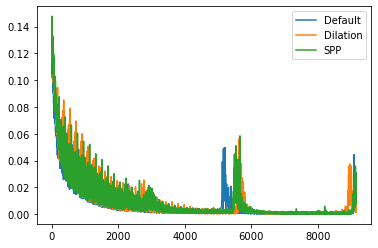

In [2]:
import numpy as np
import matplotlib.pyplot as plt

loss = np.load('./Segmentation/checkpoint/loss.npy')
loss_dil = np.load('./Segmentation/checkpoint_dil/loss.npy')
loss_spp = np.load('./Segmentation/checkpoint_spp/loss.npy')

plt.plot(loss, label='Default')
plt.plot(loss_dil, label = 'Dilation')
plt.plot(loss_spp, label = 'SPP')
plt.legend()
plt.show()

``Answer Q1.4.D here``

(3, 22)


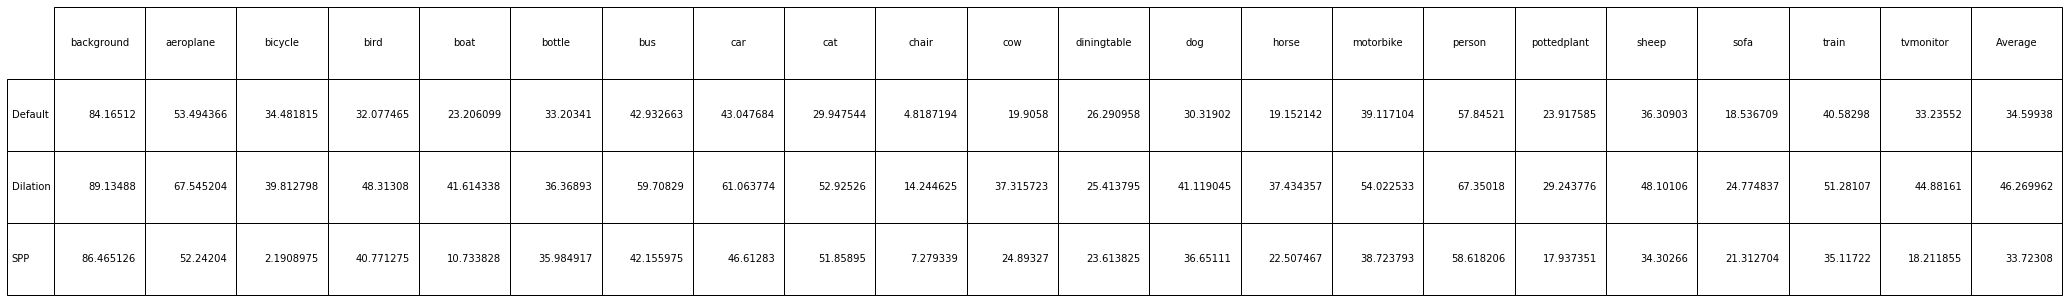

In [36]:
acc = np.load('./Segmentation/test/accuracy_50.npy')
acc_dil = np.load('./Segmentation/test_dil/accuracy_50.npy')
acc_spp = np.load('./Segmentation/test_spp/accuracy_50.npy')

acc_mean = np.mean(acc)
acc__dil_mean = np.mean(acc_dil)
acc_spp_mean = np.mean(acc_spp)

axis = ['background' ,'aeroplane' ,'bicycle' ,'bird' ,'boat', 'bottle', 'bus', 'car',
        'cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant',
        'sheep','sofa','train','tvmonitor','Average']

acc = np.append(acc, acc_mean)
acc_dil = np.append(acc_dil, acc__dil_mean)
acc_spp = np.append(acc_spp, acc_spp_mean)

result = np.vstack((acc, acc_dil))
result = np.vstack((result, acc_spp))

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table = plt.table(cellText=result, rowLabels = ['Default', 'Dilation', 'SPP'], colLabels=axis, loc='center')
table.scale(6, 6)
plt.show()

``Answer Q1.4.E here``

    The result I got from the images matches with the above table, dilation perfroms the best with least area of wrong segmentation. One obeservation is that SPP seem to be interfered a lot by the background which make sense due to its multiple level feature pooling at the end.

<module 'PIL.Image' from '/opt/conda/lib/python3.7/site-packages/PIL/Image.py'> image_base
Image Number 200
Origial Image


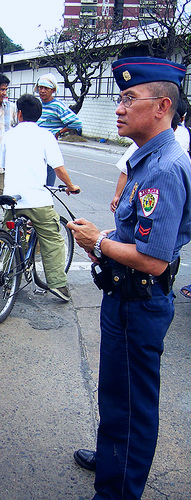

Segmentation GT


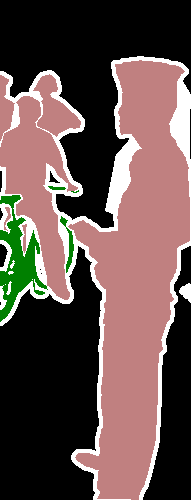

Segmentation Baseline


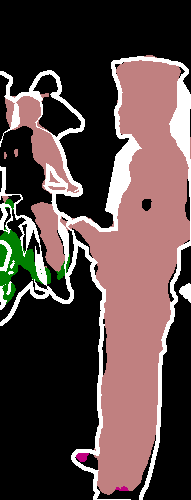

Segmentation Dilation


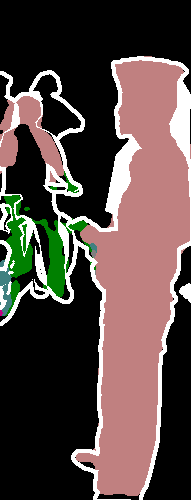

Segmentation SPP


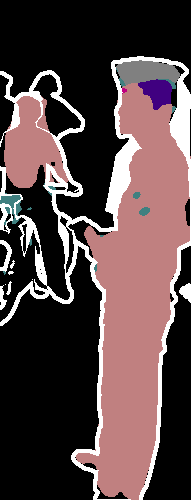

<module 'PIL.Image' from '/opt/conda/lib/python3.7/site-packages/PIL/Image.py'> image_base
Image Number 400
Origial Image


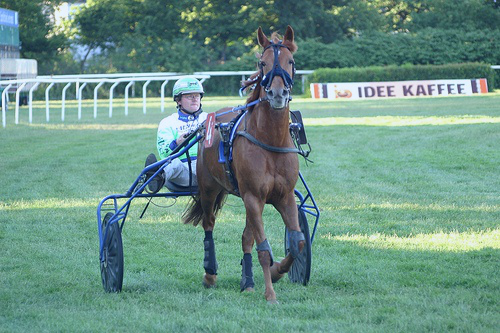

Segmentation GT


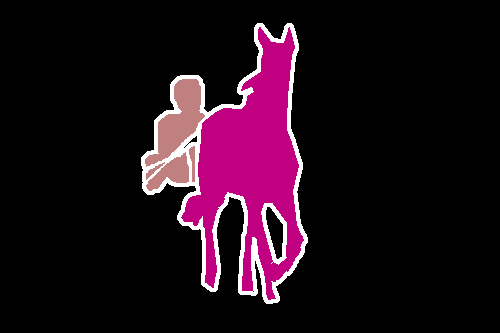

Segmentation Baseline


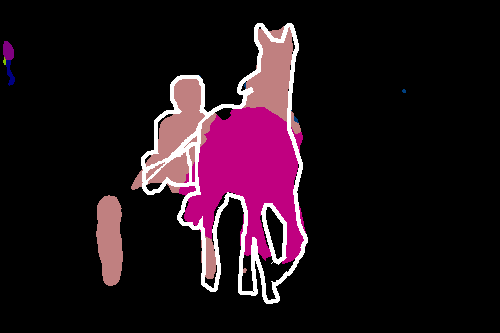

Segmentation Dilation


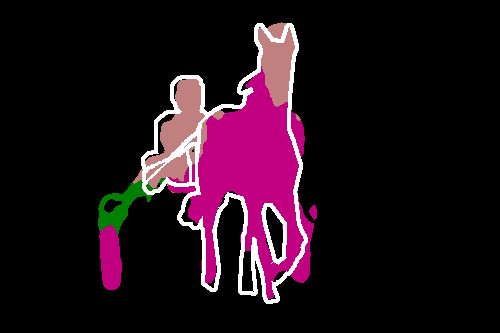

Segmentation SPP


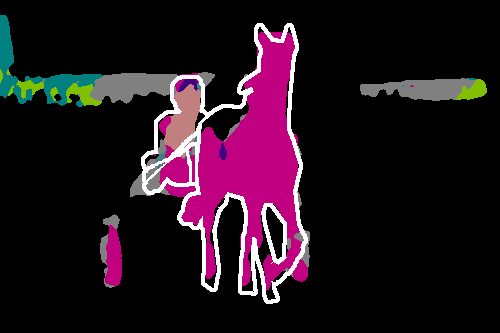

<module 'PIL.Image' from '/opt/conda/lib/python3.7/site-packages/PIL/Image.py'> image_base
Image Number 600
Origial Image


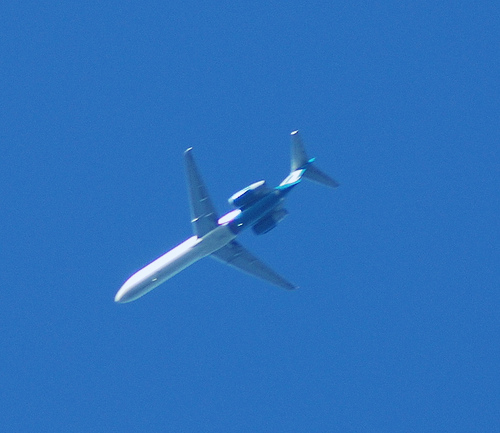

Segmentation GT


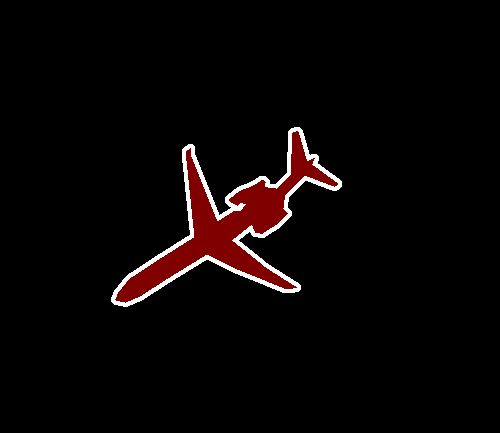

Segmentation Baseline


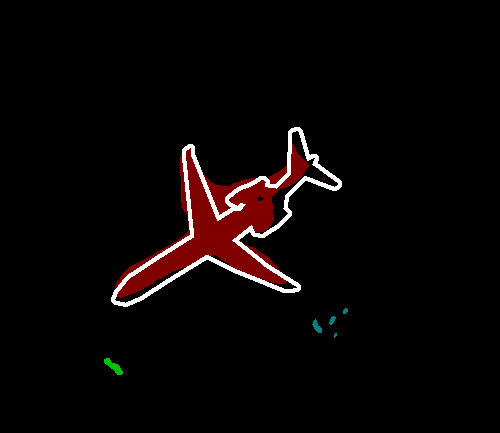

Segmentation Dilation


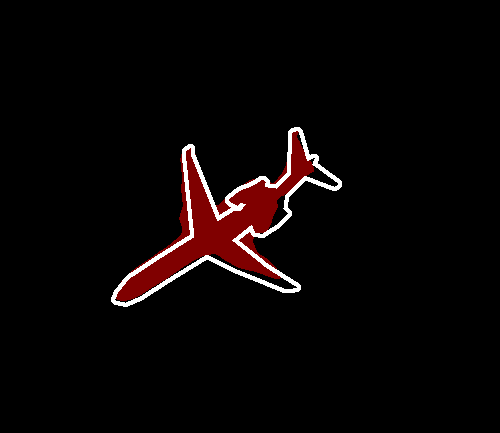

Segmentation SPP


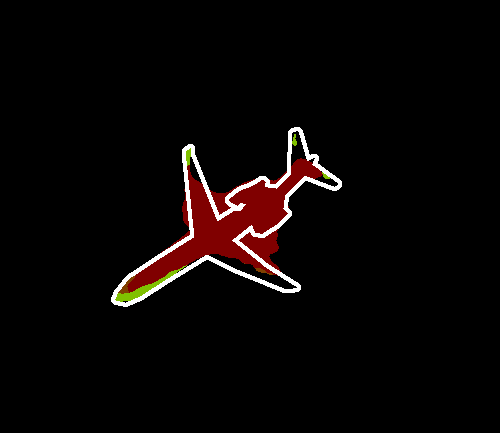

<module 'PIL.Image' from '/opt/conda/lib/python3.7/site-packages/PIL/Image.py'> image_base
Image Number 800
Origial Image


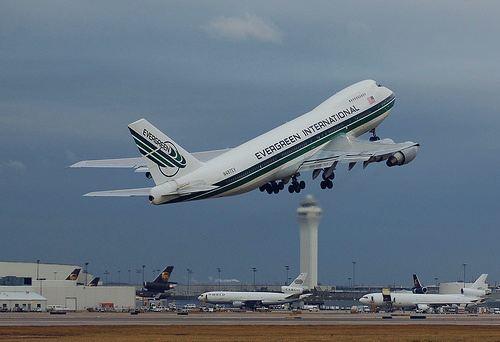

Segmentation GT


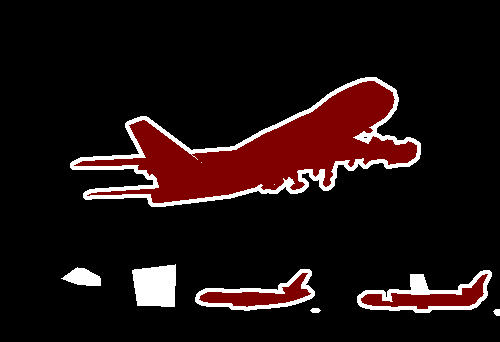

Segmentation Baseline


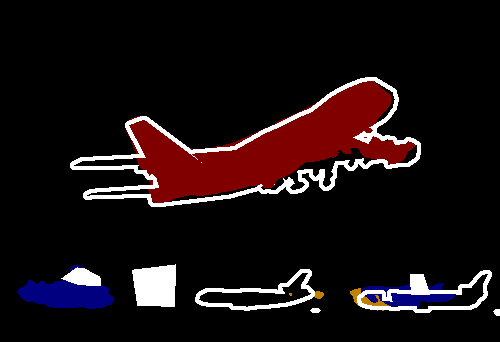

Segmentation Dilation


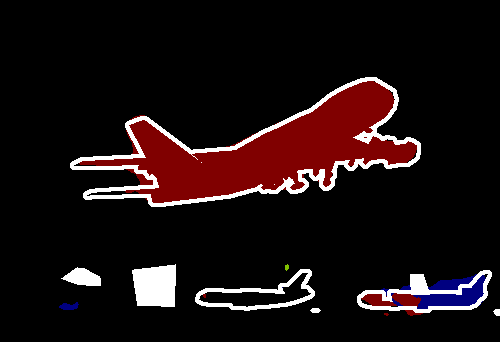

Segmentation SPP


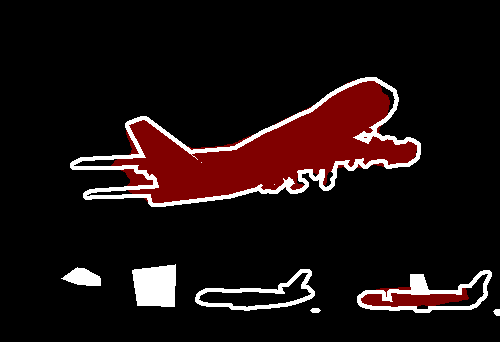

In [29]:
from PIL import Image
for i in range(4):
    print(Image, "image_base")
    image_base = (i+1)*200
    print("Image Number",image_base)
    image = Image.open(str('./Segmentation/test_combined/images_'+str(image_base)+'.png'))
    gt = Image.open(str('./Segmentation/test_combined/labelGt_'+str(image_base)+'.png'))
    base = Image.open(str('./Segmentation/test_combined/labelPred_'+str(image_base)+'.png'))
    dil = Image.open(str('./Segmentation/test_combined/labelPred_dil_'+str(image_base)+'.png'))
    spp = Image.open(str('./Segmentation/test_combined/labelPred_spp_'+str(image_base)+'.png'))
    
    print("Origial Image")
    display(image)
    print("Segmentation GT")
    display(gt)
    print("Segmentation Baseline")
    display(base)
    print("Segmentation Dilation")
    display(dil)
    print("Segmentation SPP")
    display(spp)

``Answer Q1.4.F here``

    The Increase in acutual receptive field definitaly helps with performance, but network larger receptive field might need more time to train which gives disadvantage to SPP given training settings are the same. For further imporvement, I can use a better backbone network, an adptive learning rate, generally more training epoch, and also data augmentation.

## Q2: SSD [3] Object Detection

1. **Check the codes in `Detection`.** The codes are modified from ``https://github.com/amdegroot/ssd.pytorch``. Run `eval.py` code to get the object detection average precision (AP) on the PASCAL VOC 2012 dataset. The model is already trained on the PASCAL VOC 2012 object detection dataset and stored at ``/datasets/cs252-sp21-A00-public/hw3_data/detection/weights/VOC.pth``. Draw a table in your report summarizing the AP of all 20 object categories and their mean.   **[10 points]**

``Answer Q2.1 here`` 

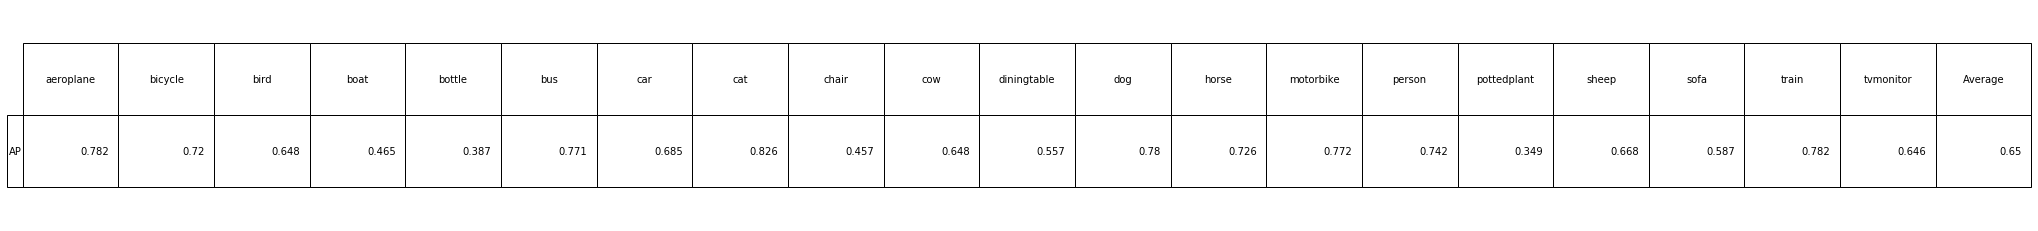

In [39]:
axis = ['aeroplane' ,'bicycle' ,'bird' ,'boat', 'bottle', 'bus', 'car',
        'cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant',
        'sheep','sofa','train','tvmonitor','Average']

result = [0.782,0.720,0.648,0.465,0.387,0.771,0.685,0.826,0.457,0.648,0.557,0.780,0.726,0.772,0.742,0.349,0.668,0.587,0.782,0.646,0.650]
final = np.zeros((1,21))
final[0] = result

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table = plt.table(cellText = final, rowLabels = ['AP'], colLabels=axis, loc='center')
table.scale(6, 6)
plt.show()

2. **Answer the following questions:**
    1.  Briefly explain how average precision is computed for PASCAL VOC 2012 dataset. Please check the code ($\mathtt{eval.py:~Line~163-191}$). In this homework, we use the Pascal VOC 2007 metric. **[10 points]** 
    2. Explain how SSD can be much faster compared to Faster RCNN [4]? **[10 points]**
    3. Usually the number of negative bounding boxes (boxes without any object) is much larger than the number of positive bounding boxes. Explain how this imbalance is handled in SSD and Faster RCNN, respectively. **[10 points]**

``Answer Q2.2.A here`` 

    AP is calculated as the average of max precision value at each record level, with the max precision value being the max precision value over all the record levels equal or larger than the current recall level.Record level is increased by 0.1 each time.

``Answer Q2.2.B here``

    SSD eliminates bounding box proposals and the subsequent pixel or feature resampling stage, it onlys uses feed forward convolution layers and filters to predict both box offset and objectness score.

``Answer Q2.2.C here``
    
    Faster RCNN: They use Fast CNN as the detectin module which inturn use predictions that has the IoU to group truth of [0.1. 0.5] as hard example, then random sample those to have 3:1negatives and positive radio.
    
    SSD: they do not use all the negative samples but sort them using the highest confidence loss for each default box and pick the top ones so that the ratio between the negatives and positives is at most 3:1.

3. Randomly pick up some images from the PASCAL VOC 2012 dataset and some from other sources. Visualize the bounding box prediction results and include a figure in your report. You can use the code in folder $\mathtt{demo}$ for visualization. **[10 points]**

``Answer Q2.3 here`` 

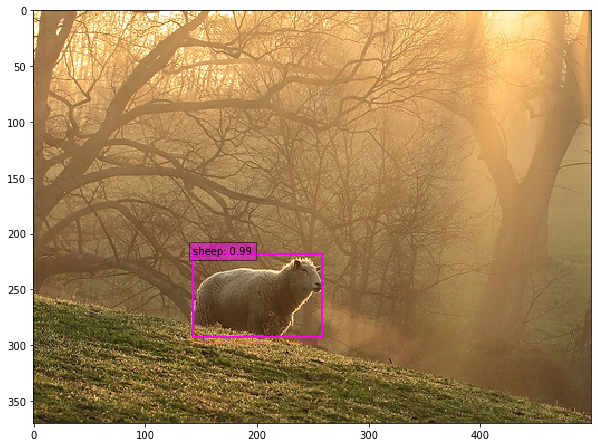

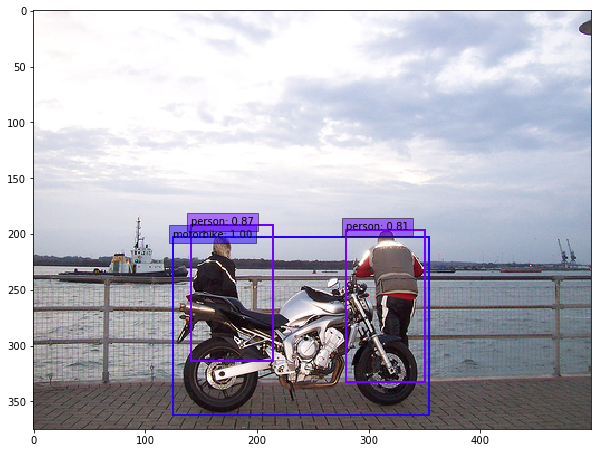

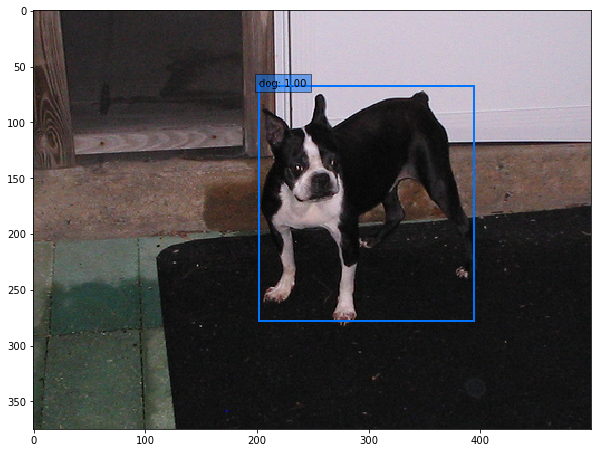

## References
1. Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions." arXiv preprint arXiv:1511.07122 (2015).
2. Zhao, Hengshuang, et al. "Pyramid scene parsing network." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
3. Liu, Wei, et al. "Ssd: Single shot multibox detector." European conference on computer vision. Springer, Cham, 2016.
4.  Ren, Shaoqing, et al. "Faster r-cnn: Towards real-time object detection with region proposal networks." Advances in neural information processing systems. 2015.